<a href="https://colab.research.google.com/github/Cloud2602/gesture_recognition/blob/main/gesture_recognition_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.9

Found existing installation: mediapipe 0.10.9
Uninstalling mediapipe-0.10.9:
  Successfully uninstalled mediapipe-0.10.9
  Using cached mediapipe-0.10.9-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
Using cached mediapipe-0.10.9-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)


In [2]:
!pip install tensorflow

In [13]:
!pip install pyrealsense2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 27.8 MB/s eta 0:00:00


In [4]:
!unzip -q "/content/dataset-hands.zip" -d "/content/dataset_hands"

In [3]:
!git clone https://github.com/Cloud2602/gesture_recognition.git

Cloning into 'gesture_recognition'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 460 (delta 0), reused 0 (delta 0), pack-reused 457 (from 1)
Receiving objects: 100% (460/460), 50.70 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Updating files: 100% (345/345), done.


In [ ]:
%cd /content/gesture_recognition
!git pull

# With real z

### Landmark Extraction

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
import csv

# --- Parameters ---
BASE_DIR = "/content/dataset_hands/dataset-hands"
OUTPUT_DIR = "/content/dataset_NOT_augmented"
radius = 40  


os.makedirs(OUTPUT_DIR, exist_ok=True)


def get_valid_depth_avg(depth_map, x, y, radius=40):
    h, w = depth_map.shape
    values = []
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w:
                d = depth_map[ny, nx]
                if d > 0:
                    values.append(d)
    return np.mean(values) if values else 0.0

# --- Setup MediaPipe ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)


header = [f'{dim}{i}_R' for i in range(21) for dim in ['x', 'y', 'z']]
header += [f'{dim}{i}_L' for i in range(21) for dim in ['x', 'y', 'z']]


for folder_name in sorted(os.listdir(BASE_DIR)):
    folder_path = os.path.join(BASE_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue

    output_csv = os.path.join(OUTPUT_DIR, f"{folder_name}.csv")
    output_npy = os.path.join(OUTPUT_DIR, f"{folder_name}.npy")
    all_landmarks = []
    count_right = count_left = count_total = 0

    with open(output_csv, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(header)

        for filename in sorted(os.listdir(folder_path)):
            if not filename.endswith("_Color.png"):
                continue

            base_name = filename.replace("_Color.png", "")
            depth_raw_path = os.path.join(folder_path, f"{base_name}_Depth.raw")
            image_path = os.path.join(folder_path, filename)
            depth_png_path = os.path.join(folder_path, f"{base_name}_Depth.png")

            # Carica immagine
            image_bgr = cv2.imread(image_path)
            depth_png = cv2.imread(depth_png_path)
            if image_bgr is None or depth_png is None or not os.path.exists(depth_raw_path):
                print(f" Error with file: {filename} in folder {folder_name}")
                continue

            height, width, _ = depth_png.shape
            depth_raw = np.fromfile(depth_raw_path, dtype=np.uint16)
            if depth_raw.size != height * width:
                print(f" Incorrect depth size for {filename} in {folder_name}")
                continue

            depth_map = depth_raw.reshape((height, width)).astype(np.float32) / 10000.0  

            for flip in [False, True]:
                img_proc = cv2.flip(image_bgr, 1) if flip else image_bgr
                img_rgb = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
                results = hands.process(img_rgb)

                right_hand = [0.0] * (21 * 3)
                left_hand = [0.0] * (21 * 3)

                if results.multi_hand_landmarks and results.multi_handedness:
                    for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                        label = handedness.classification[0].label
                        label = "Left" if label == "Right" else "Right"

                        landmarks = []
                        for lm in hand_landmarks.landmark:
                            x = lm.x
                            y = lm.y
                            px = min(int(x * width), width - 1)
                            py = min(int(y * height), height - 1)
                            z = get_valid_depth_avg(depth_map, px, py, radius=radius)
                            landmarks.extend([x, y, z])

                        if label == "Right":
                            right_hand = landmarks
                            count_right += 1
                        else:
                            left_hand = landmarks
                            count_left += 1

                combined = right_hand + left_hand
                all_landmarks.append(combined)
                csv_writer.writerow(combined)
                count_total += 1

   
    np.save(output_npy, np.array(all_landmarks))

    
    print(f"\n Cartella: {folder_name}")
    print(f" Landmark salvati in {output_csv} e {output_npy}")
    print(f" Immagini analizzate (incl. flip): {count_total}")
    print(f" Mani rilevate: Destra {count_right} | Sinistra {count_left}")
    print(f" Campioni totali: {len(all_landmarks)}")



📁 Cartella: 0
✅ Landmark salvati in /content/dataset_NOT_augmented/0.csv e /content/dataset_NOT_augmented/0.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 142 | Sinistra 138
📊 Campioni totali: 140

📁 Cartella: 1
✅ Landmark salvati in /content/dataset_NOT_augmented/1.csv e /content/dataset_NOT_augmented/1.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 67 | Sinistra 67
📊 Campioni totali: 140

📁 Cartella: 2
✅ Landmark salvati in /content/dataset_NOT_augmented/2.csv e /content/dataset_NOT_augmented/2.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 64 | Sinistra 67
📊 Campioni totali: 140

📁 Cartella: 3
✅ Landmark salvati in /content/dataset_NOT_augmented/3.csv e /content/dataset_NOT_augmented/3.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 69 | Sinistra 70
📊 Campioni totali: 140


### Add Augumentation

In [ ]:
import os
import numpy as np


def zoom_landmarks(landmarks, scale=0.8):
    center = landmarks[0]
    return (landmarks - center) * scale + center

def rotate_landmarks(landmarks, angle_deg=15):
    angle_rad = np.radians(angle_deg)
    center = landmarks[0]
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])
    rotated = np.dot(landmarks[:, :2] - center[:2], rotation_matrix) + center[:2]
    landmarks[:, :2] = rotated
    return landmarks

def translate_landmarks(landmarks, offset=(0.05, -0.03, 0.0)):
    return landmarks + np.array(offset)


input_base_dir = "/content/dataset_NOT_augmented"
output_base_dir = "/content/data_augumented"

os.makedirs(output_base_dir, exist_ok=True)

for file_name in sorted(os.listdir(input_base_dir)):
            augmented = [] 

            if file_name.endswith('.npy'):
                print(f"✔️ File: {file_name}")
                file_path = os.path.join(input_base_dir, file_name)
                landmarks = np.load(file_path)

                for i, landmark in enumerate(landmarks):
                  landmark = landmark.reshape((42, 3))  # (21 dx + 21 sx)
                  right = landmark[:21]
                  left = landmark[21:]

                  augmented.append(landmark.copy())

                  # Zoom
                  zoomed = landmark.copy()
                  if not np.allclose(right, 0.0):
                      zoomed[:21] = zoom_landmarks(right.copy(), scale=0.8)
                  if not np.allclose(left, 0.0):
                      zoomed[21:] = zoom_landmarks(left.copy(), scale=0.8)
                  augmented.append(zoomed)

                  # Rotation +15°
                  rotated_p15 = landmark.copy()
                  if not np.allclose(right, 0.0):
                      rotated_p15[:21] = rotate_landmarks(right.copy(), angle_deg=15)
                  if not np.allclose(left, 0.0):
                      rotated_p15[21:] = rotate_landmarks(left.copy(), angle_deg=15)
                  augmented.append(rotated_p15)

                  # Rotation -15°
                  rotated_m15 = landmark.copy()
                  if not np.allclose(right, 0.0):
                      rotated_m15[:21] = rotate_landmarks(right.copy(), angle_deg=-15)
                  if not np.allclose(left, 0.0):
                      rotated_m15[21:] = rotate_landmarks(left.copy(), angle_deg=-15)
                  augmented.append(rotated_m15)

                  # Translation +
                  translated_p = landmark.copy()
                  if not np.allclose(right, 0.0):
                      translated_p[:21] = translate_landmarks(right.copy(), offset=(0.05, -0.03, 0.0))
                  if not np.allclose(left, 0.0):
                      translated_p[21:] = translate_landmarks(left.copy(), offset=(0.05, -0.03, 0.0))
                  augmented.append(translated_p)

                  # Translation -
                  translated_m = landmark.copy()
                  if not np.allclose(right, 0.0):
                      translated_m[:21] = translate_landmarks(right.copy(), offset=(-0.05, 0.03, 0.0))
                  if not np.allclose(left, 0.0):
                      translated_m[21:] = translate_landmarks(left.copy(), offset=(-0.05, 0.03, 0.0))
                  augmented.append(translated_m)

            else:
                print(f"File not valid: {file_name}")

            print("augumented lenght: ", len(augmented))
            new_name = f"{os.path.splitext(file_name)[0]}.npy"
            save_path = os.path.join(output_base_dir, new_name)
            np.save(save_path, augmented)
            print(f"File salvato: {save_path}")

⚠️ File non valido: 0.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/0.npy
✔️ File: 0.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/0.npy
⚠️ File non valido: 1.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/1.npy
✔️ File: 1.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/1.npy
⚠️ File non valido: 2.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/2.npy
✔️ File: 2.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/2.npy
⚠️ File non valido: 3.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/3.npy
✔️ File: 3.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/3.npy


Discard all zeros samples

In [ ]:
import os
import numpy as np

TARGET_DIR = "/content/data_augumented"

for filename in sorted(os.listdir(TARGET_DIR)):
    if not filename.endswith(".npy"):
        continue

    file_path = os.path.join(TARGET_DIR, filename)
    print(f"\nFile: {filename}")

    data = np.load(file_path)
    print(f"Total initial samples: {len(data)}")

    filtered = []
    for i, sample in enumerate(data):
        sample = sample.reshape((42, 3))
        right = sample[:21]
        left = sample[21:]

        right_zero = np.allclose(right, 0.0)
        left_zero = np.allclose(left, 0.0)

        if right_zero and left_zero:
            print(f" Sample {i} removed: ALL ZEROS")
            continue

        filtered.append(sample)

    # Salva sovrascrivendo il file originale
    filtered = np.array(filtered)
    np.save(file_path, filtered)
    print(f" New file saved: {len(filtered)} samples written to '{filename}'")



📂 File: 0.npy
🔢 Sample totali iniziali: 840
✅ Nuovo file salvato: 840 sample scritti in '0.npy'

📂 File: 1.npy
🔢 Sample totali iniziali: 840
🗑️  Sample 156 rimosso: TUTTO ZERO
🗑️  Sample 157 rimosso: TUTTO ZERO
🗑️  Sample 158 rimosso: TUTTO ZERO
🗑️  Sample 159 rimosso: TUTTO ZERO
🗑️  Sample 160 rimosso: TUTTO ZERO
🗑️  Sample 161 rimosso: TUTTO ZERO
🗑️  Sample 162 rimosso: TUTTO ZERO
🗑️  Sample 163 rimosso: TUTTO ZERO
🗑️  Sample 164 rimosso: TUTTO ZERO
🗑️  Sample 165 rimosso: TUTTO ZERO
🗑️  Sample 166 rimosso: TUTTO ZERO
🗑️  Sample 167 rimosso: TUTTO ZERO
🗑️  Sample 180 rimosso: TUTTO ZERO
🗑️  Sample 181 rimosso: TUTTO ZERO
🗑️  Sample 182 rimosso: TUTTO ZERO
🗑️  Sample 183 rimosso: TUTTO ZERO
🗑️  Sample 184 rimosso: TUTTO ZERO
🗑️  Sample 185 rimosso: TUTTO ZERO
🗑️  Sample 186 rimosso: TUTTO ZERO
🗑️  Sample 187 rimosso: TUTTO ZERO
🗑️  Sample 188 rimosso: TUTTO ZERO
🗑️  Sample 189 rimosso: TUTTO ZERO
🗑️  Sample 190 rimosso: TUTTO ZERO
🗑️  Sample 191 rimosso: TUTTO ZERO
🗑️  Sample 456 rim

### Training

In [11]:
!python /content/gesture_recognition/train.py

2025-06-30 09:18:14.508986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751275094.573970    5965 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751275094.593425    5965 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-30 09:18:20.904064: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

### Test Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
✅ Predizione: Classe 3 (softmax: [1.0603949e-06 5.1406170e-07 3.0254082e-06 9.9999535e-01])


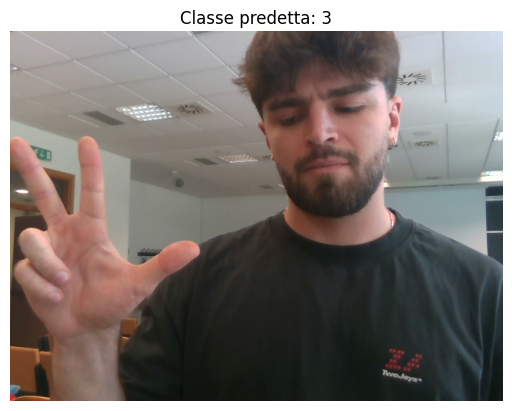

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model

model_path = "best_model.h5"
image_path = "/content/dataset_hands/dataset-hands/3/33_Color.png"
depth_path = "/content/dataset_hands/dataset-hands/3/33_Depth.raw"

depth_shape = (480, 640)  
if depth_path.split('/')[4] == '3':
  depth_shape = (320,240)
depth_dtype = np.uint16
depth_scale = 0.0001  
radius = 40  

def get_valid_depth_avg(depth_map, x, y, radius=40):
    h, w = depth_map.shape
    values = []
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w:
                d = depth_map[ny, nx]
                if d > 0:
                    values.append(d)
    return np.mean(values) if values else 0.0


color_image = cv2.imread(image_path)
color_image_shape = color_image.shape
depth_image = np.fromfile(depth_path, dtype=depth_dtype).reshape(depth_shape)

h, w, _ = color_image.shape
mean = np.load("/content/scaler_mean.npy")
std = np.load("/content/scaler_scale.npy")

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
rgb_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
result = hands.process(rgb_image)

if not result.multi_hand_landmarks:
    print("No hand detected.")
    exit()

def get_landmark_xyz(landmarks, depth_img, h, w):
    xyz = []
    for lm in landmarks.landmark:
        x_px = int(lm.x * w)
        y_px = int(lm.y * h)
        if 0 <= x_px < w and 0 <= y_px < h:
            z = get_valid_depth_avg(depth_img, x_px, y_px, radius=radius) * depth_scale
        else:
            z = 0.0
        xyz.extend([lm.x, lm.y, z])
    return np.array(xyz)


first_hand_xyz = get_landmark_xyz(result.multi_hand_landmarks[0], depth_image, h, w)

if len(result.multi_hand_landmarks) > 1:
    second_hand_xyz = get_landmark_xyz(result.multi_hand_landmarks[1], depth_image, h, w)
else:
    second_hand_xyz = np.zeros_like(first_hand_xyz)

input_vector = np.concatenate([first_hand_xyz, second_hand_xyz]).reshape(1, -1)
input_vector = (input_vector - mean) / std

model = load_model(model_path)
prediction = model.predict(input_vector)
predicted_class = np.argmax(prediction)

print(f"Prediction: Class {predicted_class} (softmax: {prediction[0]})")

import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()